# Recommendation System

Building recommendation system to scale using scikit-surprise (surprise library)

[Recommender systems](https://en.wikipedia.org/wiki/Recommender_system) are one of the most common used and easily understandable applications of data science. Lots of work has been done on this topic, the interest and demand in this area remains very high because of the rapid growth of the internet and the information overload problem. It has become necessary for online businesses to help users to deal with information overload and provide personalized recommendations, content and services to them.

Two of the most popular ways to approach recommender systems are [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) and [content-based recommendations](https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/). In this post, we will focus on the **collaborative filtering** approach, that is: the user is recommended items that people with similar tastes and preferences liked in the past. In another word, this method predicts unknown ratings by using the similarities between users.

## Installing required libraries

In [1]:
!pip3 install numpy
!pip3 install scikit-surprise

## Importing required libraries

In [2]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

## Importing data

GroupLens Research has collected and made available rating data sets from the MovieLens web site ([http://movielens.org](http://movielens.org/)). The data sets were collected over various periods of time, depending on the size of the set.

We are using *Small*: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

Download: [ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) (size: 1 MB)

In [3]:
df = pd.read_csv ("https://raw.githubusercontent.com/singhsidhukuldeep/Recommendation-System/master/data/ratings.csv")

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [6]:
df.drop(['timestamp'], axis=1, inplace=True)
df.columns = ['userID', 'item', 'rating']

In [7]:
df.head()

,userID,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [8]:
df.shape

(100836, 3)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userID  100836 non-null  int64  
 1   item    100836 non-null  int64  
 2   rating  100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [10]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::20000, :])

Dataset shape: (100836, 3)
-Dataset examples-
        userID  item  rating
0            1     1     4.0
20000      132  1079     3.5
40000      274  5621     2.0
60000      387  6748     3.0
80000      501    11     3.0
100000     610  6978     4.0


## EDA

### Ratings Distribution

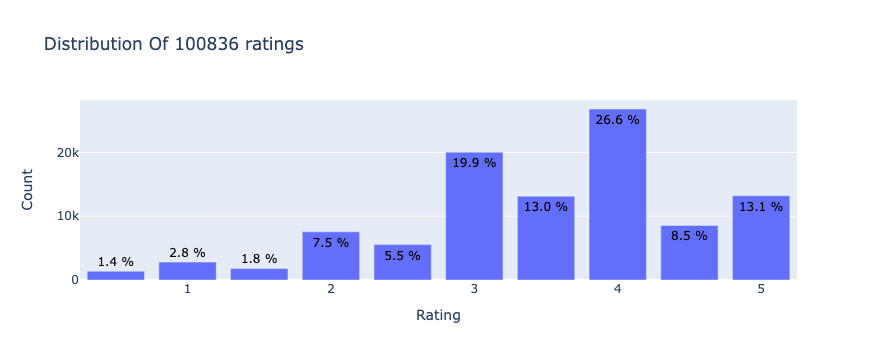

In [11]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

### Ratings Distribution By Item

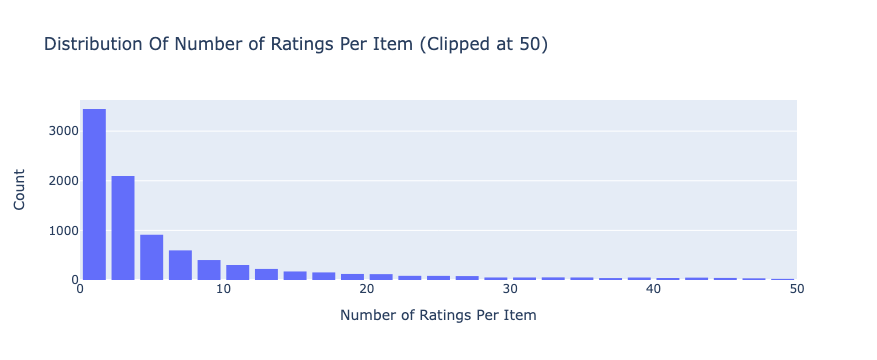

In [12]:
# Number of ratings per book
data = df.groupby('item')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Item (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [13]:
df.groupby('item')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,item,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
224,260,251
418,480,238
97,110,237
507,589,224
461,527,220


### Ratings Distribution By User

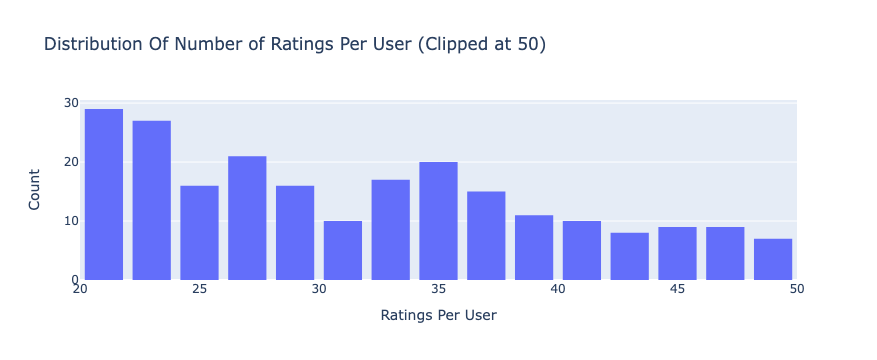

In [14]:
# Number of ratings per user
data = df.groupby('userID')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [15]:
df.groupby('userID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userID,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


### Dimensionality

To reduce the dimensionality of the dataset, we will filter out rarely rated movies and rarely rating users

In [16]:
min_ratings = 5
filter_items = df['item'].value_counts() > min_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 5
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['item'].isin(filter_items)) & (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(100836, 3)
The new data frame shape:	(88364, 3)


In [19]:
df

,userID,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


## Surprise

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [17]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new[['userID', 'item', 'rating']], reader)

### Basic algorithms

With the Surprise library, we will benchmark the following algorithms



#### NormalPredictor

* NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

* BasiclineOnly algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms

#### KNNBasic

* KNNBasic is a basic collaborative filtering algorithm.

#### KNNWithMeans

* KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

#### KNNWithZScore

* KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

#### KNNBaseline

* KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms

#### SVD

* SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

#### SVDpp

* The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

#### NMF

* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

### Slope One

* Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

### Co-clustering

* Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)


We use rmse as our accuracy metric for the predictions.

In [20]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x13298a9d0>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x1356d6f10>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x13472c810>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x13658c8d0>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x13298aa90>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x13298b410>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x13298b2d0>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x13298b210>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x13618cdd0>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x13298b110>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x13298b090>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x13298a9d0>


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x13298a9d0> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x1356d6f10>


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x1356d6f10> 


Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x13472c810>


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x13472c810> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x13658c8d0>


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x13658c8d0> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x13298aa90>


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x13298aa90> 


Starting:  <surprise.prediction_algorithms.knns.KNNBaseline object at 0x13298b410>
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.knns.KNNBaseline object at 0x13298b410> 


Starting:  <surprise.prediction_algorithms.knns.KNNBasic object at 0x13298b2d0>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.knns.KNNBasic object at 0x13298b2d0> 


Starting:  <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x13298b210>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x13298b210> 


Starting:  <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x13618cdd0>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x13618cdd0> 


Starting:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x13298b110>
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Done:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x13298b110> 


Starting:  <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x13298b090>


/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Done:  <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x13298b090> 



	DONE



/var/folders/91/g1qz4qmd3v347q0yzk9zj5tr0000gp/T/ipykernel_5158/4026352989.py:16: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

SVDpp is performing best but it is taking a lot of time so we will use SED instean but apply GridSearch CV.

In [ ]:
# param_grid = {
#     "n_epochs": [5, 10, 15, 20, 30, 40, 50, 100],
#     "lr_all": [0.001, 0.002, 0.005],
#     "reg_all": [0.02, 0.08, 0.4, 0.6]
# }

# smaller grid for testing
param_grid = {
    "n_epochs": [10, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.02]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["rmse"])

In [ ]:
from datetime import datetime
print(training_parameters)
reader = Reader(rating_scale=(1, 5))

print("\n\n\t\t STARTING\n\n")
start = datetime.now()

print("> Loading data...")
data = Dataset.load_from_df(df_new[['userID', 'item', 'rating']], reader)
print("> OK")

print("> Creating trainset...")
trainset = data.build_full_trainset()
print("> OK")


startTraining = datetime.now()
print("> Training...")

algo = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

algo.fit(trainset)

endTraining = datetime.now()
print("> OK \t\t It Took: ", (endTraining-startTraining).seconds, "seconds")

end = datetime.now()
print (">> DONE \t\t It Took", (end-start).seconds, "seconds" )

In [ ]:
## SAVING TRAINED MODEL
from surprise import dump
import os
model_filename = "./model.pickle"
print (">> Starting dump")
# Dump algorithm and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=algo)
print (">> Dump done")
print(model_filename)

In [ ]:
## LOAD SAVED MODEL
def load_model(model_filename):
    print (">> Loading dump")
    from surprise import dump
    import os
    file_name = os.path.expanduser(model_filename)
    _, loaded_model = dump.load(file_name)
    print (">> Loaded dump")
    return loaded_model

In [ ]:
# predicitng
from pprint import pprint as pp
model_filename = "./model.pickle"
def itemRating(user, item):
    uid = str(user)
    iid = str(item)
    loaded_model = load_model(model_filename)
    prediction = loaded_model.predict(user, item, verbose=True)
    rating = prediction.est
    details = prediction.details
    uid = prediction.uid
    iid = prediction.iid
    true = prediction.r_ui
    ret = {
        'user': user,
        'item': item,
        'rating': rating,
        'details': details,
        'uid': uid,
        'iid': iid,
        'true': true
        }
    pp (ret)
    print ('\n\n')
    return ret
print(itemRating(user = "610", item = "10"))